A continous depth model, differential equation solver  
How can we treat odeint as layers for building deep models?

In [22]:
# Preliminaries, training a resnet network
import jax.numpy as jnp

def mlp(params, inputs):
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnp.tanh(outputs)
    return outputs

In [23]:
def resnet(params, inputs, depth):
    for i in range(depth):
        inputs = mlp(params, inputs) + inputs
    return inputs

To fit this model to data, we also need a loss, an initializer, and an optimizer:

In [24]:
import numpy.random as npr
from jax import jit, grad

resnet_depth = 3

def resnet_squared_loss(params, inputs, targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean((preds - targets)**2)

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return[(scale * rng.randn(m, n), scale * rng.randn(n))
           for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def resnet_update(params, inputs, targets):
    grads = grad(resnet_squared_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)]

## Define hyperparameters
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

In [25]:
# dummy data
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# initialize and train
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
    resnet_params = resnet_update(resnet_params, inputs, targets)

Text(0, 0.5, 'output')

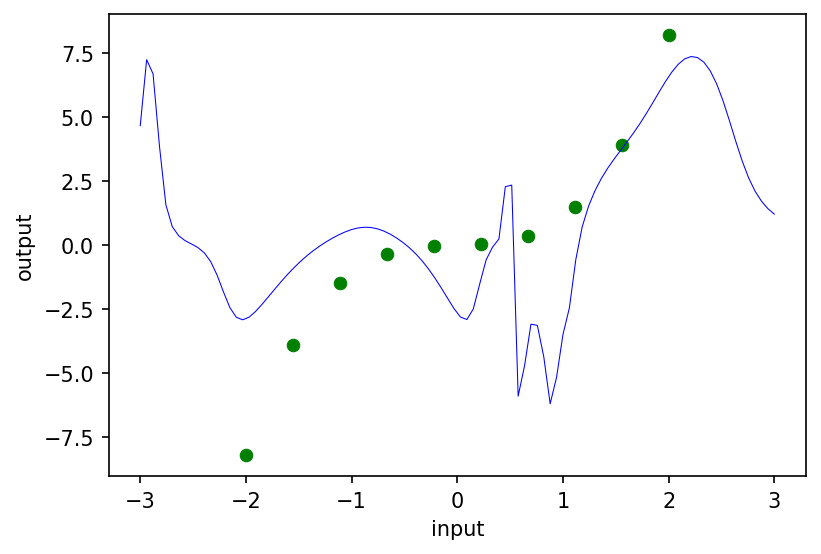

In [26]:
# Plot resulting model.
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')